IMPORTS

In [12]:
import torch
import torchvision.datasets as dset
import torchvision.models as models
import math
import random
import os
import torchvision.transforms as trans
import torch.nn.functional as F

In [7]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
def get_preds(model, inputs, dataset_name, correct_class=None, batch_size=25, return_cpu=True):
    num_batches = int(math.ceil(inputs.size(0) / float(batch_size)))
    softmax = torch.nn.Softmax()
    all_preds, all_probs = None, None
    transform = trans.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    for i in range(num_batches):
        upper = min((i + 1) * batch_size, inputs.size(0))
        input = apply_normalization(inputs[(i * batch_size):upper], dataset_name)
        with torch.no_grad():
            # input_var = torch.autograd.Variable(input.cuda(), volatile=True)
            output = torch.nn.functional.softmax(model.forward(input.cuda()))
            if correct_class is None:
                prob, pred = output.max(1)
            else:
                prob, pred = output[:, correct_class], torch.autograd.Variable(torch.ones(output.size()) * correct_class)
            if return_cpu:
                prob = prob.data.cpu()
                pred = pred.data.cpu()
            else:
                prob = prob.data
                pred = pred.data
            if i == 0:
                all_probs = prob
                all_preds = pred
            else:
                all_probs = torch.cat((all_probs, prob), 0)
                all_preds = torch.cat((all_preds, pred), 0)
    return all_preds, all_probs

In [3]:
model = getattr(models, 'mobilenet_v2')(weights=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to designated device (Use GPU when on Colab)
model = model.to(device)

NORMALIZATION OF INPUT

In [9]:
def apply_normalization(imgs, dataset):
    mean = IMAGENET_MEAN
    std = IMAGENET_STD

    imgs_tensor = imgs.clone()
    if dataset == 'mnist':
        imgs_tensor = (imgs_tensor - mean[0]) / std[0]
    else:
        if imgs.dim() == 3:
            for i in range(imgs_tensor.size(0)):
                imgs_tensor[i, :, :] = (imgs_tensor[i, :, :] - mean[i]) / std[i]
        else:
            for i in range(imgs_tensor.size(1)):
                imgs_tensor[:, i, :, :] = (imgs_tensor[:, i, :, :] - mean[i]) / std[i]
    return imgs_tensor

IMPROVED SimBA ATTACK STRATEGY

In [89]:
class SimBA:
    def __init__(self, model, dataset, image_size):
        self.model = model
        self.dataset = dataset
        self.image_size = image_size
        self.model.eval()
    
    def expand_vector(self, x, size):
        batch_size = x.size(0)
        x = x.view(-1, 3, size, size)
        z = torch.zeros(batch_size, 3, self.image_size, self.image_size)
        z[:, :, :size, :size] = x
        return z
        
    def normalize(self, x):
        return apply_normalization(x, self.dataset)

    def get_probs(self, x, y):
        ############################
        output = self.model(self.normalize(x.cuda())).cpu()
        # output = self.model(self.normalize(x)).cpu()
        probs = torch.index_select(F.softmax(output, dim=-1).data, 1, y)
        return torch.diag(probs)
    
    def get_preds(self, x):
        ############################
        output = self.model(self.normalize(x.cuda())).cpu()
        # output = self.model(self.normalize(x)).cpu()
        _, preds = output.data.max(1)
        return preds

    def simba_single_mod(self, x, y, num_iters=10000, epsilon=0.2):
        n_dims = x.view(1, -1).size(1)
        perm = torch.randperm(n_dims)
        x = x.unsqueeze(0)
        last_prob = self.get_probs(x, y)
        init_label = self.get_preds(x)
        # for i in range(num_iters):
        i=0
        new_lab = init_label
        # ind = perm[0]
        flag = False
        while new_lab==init_label:
            diff = torch.zeros(n_dims)
            
            if flag:
                if random.randint(0,1):
                    diff[perm[i]+1] = epsilon
                else:
                    diff[perm[i]-1] = epsilon
            else:
                diff[perm[i+1]] = epsilon
            i+=1

            left_prob = self.get_probs((x - diff.view(x.size())).clamp(0, 1), y)
            flag = False
            while left_prob > last_prob:
                # diff =
                flag = True
                x = (x - diff.view(x.size())).clamp(0, 1) # finalize
                last_prob = left_prob
                diff[perm[i]] += epsilon
                left_prob = self.get_probs((x - diff.view(x.size())).clamp(0, 1), y)
            if not flag:
                right_prob = self.get_probs((x + diff.view(x.size())).clamp(0, 1), y)
                while right_prob > last_prob:
                    flag = True
                    x = (x + diff.view(x.size())).clamp(0, 1)
                    last_prob = right_prob
                    diff[perm[i]] += epsilon
                    right_prob = self.get_probs((x + diff.view(x.size())).clamp(0, 1), y)
            new_lab = self.get_preds(x)
            if i % 500 == 0:
                print(i,last_prob)
        return x.squeeze()

    def simba_single_imp(self, x, y, epsilon=0.2):
        n_dims = x.view(1, -1).size(1)
        perm = torch.randperm(n_dims)
        x = x.unsqueeze(0)
        last_prob = self.get_probs(x, y)
        new_lab = self.get_preds(x)
        # for i in range(num_iters):
        i=0
        flag = False
        while new_lab!=y:
            diff = torch.zeros(n_dims)
            
            if flag:
                if random.randint(0,1):
                    if perm[i] == n_dims-1:
                        diff[perm[i]-1] = epsilon
                    else:
                        diff[perm[i]+1] = epsilon
                else:
                    if perm[i]==0:
                        diff[perm[i]+1] = epsilon
                    else:    
                        diff[perm[i]-1] = epsilon
            else:
                diff[perm[i+1]] = epsilon
            i+=1

            left_prob = self.get_probs((x - diff.view(x.size())).clamp(0, 1), y)
            flag = False
            while left_prob > last_prob:
                flag = True
                x = (x - diff.view(x.size())).clamp(0, 1) # finalize
                last_prob = left_prob
                diff[perm[i]] += epsilon
                left_prob = self.get_probs((x - diff.view(x.size())).clamp(0, 1), y)
            if not flag:
                right_prob = self.get_probs((x + diff.view(x.size())).clamp(0, 1), y)
                while right_prob > last_prob:
                    flag = True
                    x = (x + diff.view(x.size())).clamp(0, 1)
                    last_prob = right_prob
                    diff[perm[i]] += epsilon
                    right_prob = self.get_probs((x + diff.view(x.size())).clamp(0, 1), y)
            new_lab = self.get_preds(x)
            # if i % 500 == 0:
            #     print(i,last_prob)
        print("Total iterations = ",i)
        return x.squeeze(), i


TARGETED ATTACK RUN #1

In [16]:
# model_name='mobilenet_v2'
# model = getattr(models, model_name)(pretrained=True)
model.eval()
image_size = 64
attacker = SimBA(model, 'imagenet', image_size)

testset = dset.ImageFolder('subset/val', IMAGENET_TRANSFORM)
x,_ = testset[random.randint(0, len(testset) - 1)]  # image we want
x_f,_ = testset[random.randint(0, len(testset) - 1)]  # target we wanna be

output = attacker.model(attacker.normalize(x.unsqueeze(0)).cuda()).cpu()

output_fake = attacker.model(attacker.normalize(x_f.unsqueeze(0)).cuda()).cpu()
y_fake = torch.argmax(output_fake)

res, i = attacker.simba_single_imp(x,y_fake,num_iters=1000)
output_later = attacker.model(attacker.normalize(res.unsqueeze(0)).cuda()).cpu()



500 tensor([0.0005])
1000 tensor([0.0017])


TARGETED ATTACK RUN #2

In [20]:
# model_name='mobilenet_v2'
# model = getattr(models, model_name)(pretrained=True)
x,_ = testset[random.randint(0, len(testset) - 1)]  # image we want
x_f,_ = testset[random.randint(0, len(testset) - 1)]  # target we wanna be

output = attacker.model(attacker.normalize(x.unsqueeze(0)).cuda()).cpu()

output_fake = attacker.model(attacker.normalize(x_f.unsqueeze(0)).cuda()).cpu()
y_fake = torch.argmax(output_fake)

res = attacker.simba_single_imp(x,y_fake,num_iters=1000)
output_later = attacker.model(attacker.normalize(res.unsqueeze(0)).cuda()).cpu()

500 tensor([0.0006])
1000 tensor([0.0071])
1500 tensor([0.0386])
Total iterations =  1740


VISUALIZATION #1

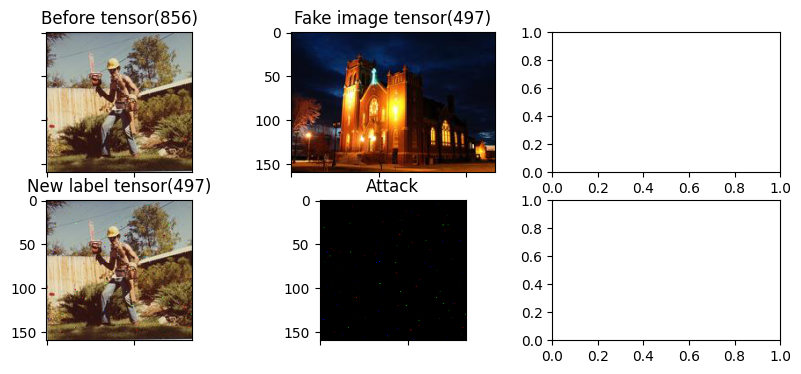

In [19]:
# 400 iterations!!!
from matplotlib import pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 4))

for i,ax in enumerate(axes):
    if i==0:
        ax[0].imshow(np.transpose(x,(1,2,0))) 
        ax[0].set_title('Before '+str(torch.argmax(output)))
        ax[0].set(xticklabels=[])
        ax[0].set(yticklabels=[])
        ax[1].imshow(np.transpose(x_f,(1,2,0))) 
        ax[1].set_title('Fake image '+str(y_fake))
        ax[1].set(xticklabels=[])
        ax[1].set_ylabel('')
    else:
        ax[0].imshow(np.transpose(res,(1,2,0)))
        ax[0].set_title('New label '+str(torch.argmax(output_later)))
        ax[0].set(xticklabels=[])
        ax[0].set_ylabel('')
        ax[1].imshow(np.transpose(res-x,(1,2,0)))
        ax[1].set_title('Attack')
        ax[1].set(xticklabels=[])
        ax[1].set_ylabel('')

plt.show()

VISUALIZATION #2

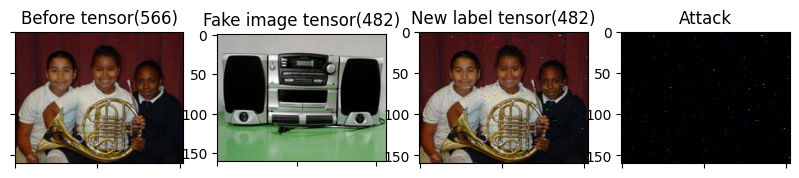

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 4))

for i,ax in enumerate(axes):
    if i==0:
        ax.imshow(np.transpose(x,(1,2,0))) 
        ax.set_title('Before '+str(torch.argmax(output)))
        ax.set(xticklabels=[])
        ax.set(yticklabels=[])
    elif i==1:
        ax.imshow(np.transpose(x_f,(1,2,0))) 
        ax.set_title('Fake image '+str(y_fake))
        ax.set(xticklabels=[])
        ax.set_ylabel('')
    elif i==2:
        ax.imshow(np.transpose(res,(1,2,0)))
        ax.set_title('New label '+str(torch.argmax(output_later)))
        ax.set(xticklabels=[])
        ax.set_ylabel('')
    else:
        ax.imshow(np.transpose(res-x,(1,2,0)))
        ax.set_title('Attack')
        ax.set(xticklabels=[])
        ax.set_ylabel('')

plt.show()

TARGETED ATTACKS ON 100 IMAGES FOR BENCHMARKING, FAKE LABEL PAIR FOR EACH

In [29]:
import numpy as np
it = []
init = []
new = []
fakes = []
attacker = SimBA(model, 'imagenet', image_size)
for i in range(100):
    x,_ = testset[random.randint(0, len(testset) - 1)]  # image we want
    x_f,_ = testset[random.randint(0, len(testset) - 1)]  # target we wanna be

    output = attacker.model(attacker.normalize(x.unsqueeze(0)).cuda()).cpu()

    output_fake = attacker.model(attacker.normalize(x_f.unsqueeze(0)).cuda()).cpu()
    y_fake = torch.argmax(output_fake)
    if torch.argmax(output)==y_fake:
        continue

    res, y = attacker.simba_single_imp(x,y_fake,num_iters=1000)
    it.append(y)
    init.append(x)
    fakes.append(x_f)
    new.append(res)
    output_later = attacker.model(attacker.normalize(res.unsqueeze(0)).cuda()).cpu()

Total iterations =  4743
Total iterations =  2391
Total iterations =  2187
Total iterations =  1842
Total iterations =  1898
Total iterations =  3457
Total iterations =  3564
Total iterations =  4238
Total iterations =  1488
Total iterations =  869
Total iterations =  1641
Total iterations =  1926
Total iterations =  498
Total iterations =  715
Total iterations =  723
Total iterations =  1622
Total iterations =  4295
Total iterations =  3865
Total iterations =  1340
Total iterations =  2457
Total iterations =  826
Total iterations =  2005
Total iterations =  5011
Total iterations =  1307
Total iterations =  11782
Total iterations =  1584
Total iterations =  1723
Total iterations =  1354
Total iterations =  981
Total iterations =  1965
Total iterations =  1298
Total iterations =  7287
Total iterations =  1615
Total iterations =  1764
Total iterations =  3217
Total iterations =  1599
Total iterations =  2089
Total iterations =  4079
Total iterations =  1021
Total iterations =  1231
Total

In [30]:
print("Avg iterations to change = ",np.mean(it))

Avg iterations to change =  2215.6666666666665


TARGETED SPECIFIC LABEL ATTACK ON 100 IMAGES -- SAY, TO CLASSIFY AS FUEL PUMP

In [ ]:
import numpy as np
from time import time
from tqdm import tqdm

IMAGENET_SIZE = 224
IMAGENET_TRANSFORM = trans.Compose([
    trans.ToTensor()])

testset = dset.ImageFolder('subset/val', IMAGENET_TRANSFORM)
attacker = SimBA(model, 'imagenet', IMAGENET_SIZE)

In [ ]:
import pickle
labels = pickle.load(open('labels.pkl','rb'))

GET THE RANDOM FAKE LABEL

In [83]:
fake_ind = random.randint(0, len(testset) - 1)
x_f,_ = testset[fake_ind]  # target we wanna be
y_fake = attacker.get_preds(x_f.unsqueeze(0))
y_fake.item(), labels[y_fake.item()]

(571, 'gas pump, gasoline pump, petrol pump, island dispenser')

PERFORM ATTACKS

In [84]:
init = []
while len(init)<100:
    index = random.randint(0, len(testset) - 1)
    x,_ = testset[index]
    output = attacker.get_preds(x.unsqueeze(0))
    if output==y_fake:
        continue
    init.append({"index":index,"i":x,"l":output})

In [90]:
it = []
new = []
start = time()
for im in init:
    x = im["i"]
    res, num_iter = attacker.simba_single_imp(x,y_fake)
    it.append(num_iter)
    # fakes.append({"i":x_f,"l":y_fake})
    
    output_later = attacker.get_preds(res.unsqueeze(0))
    new.append({"i":res,"l":output_later})
print(f"Avg iterations to change {i+1} = {np.mean(it)}")
end = time()
end - start

5968.047237634659

CHECK IF ANY UNATTACKED IMAGES PRESENT

In [92]:
s = []
for i in range(len(it)):
    if new[i]["l"]!=571:
        s.append(i)

s

[]

AVG ITERATIONS TO ATTACK

In [93]:
len(it), np.mean(it)

(100, 992.16)

SAVE FOR BACKUP

In [94]:
import pickle
pickle.dump(init,open('targetedv2_mobilenet/original_data_fuelpump.pkl','wb'))
# pickle.dump(fakes,open('targetedv2_mobilenet/target_data.pkl','wb'))
pickle.dump(new,open('targetedv2_mobilenet/attacked_data_fuelpump.pkl','wb'))
# pickle.dump(it,open('targetedv2_mobilenet/iterations_springer.pkl','wb'))


In [ ]:
import pickle
init = pickle.load(open('targetedv2_mobilenet/original_data_fuelpump.pkl','rb'))
new = pickle.load(open('targetedv2_mobilenet/attacked_data_fuelpump.pkl','rb'))

VISUALIZATION

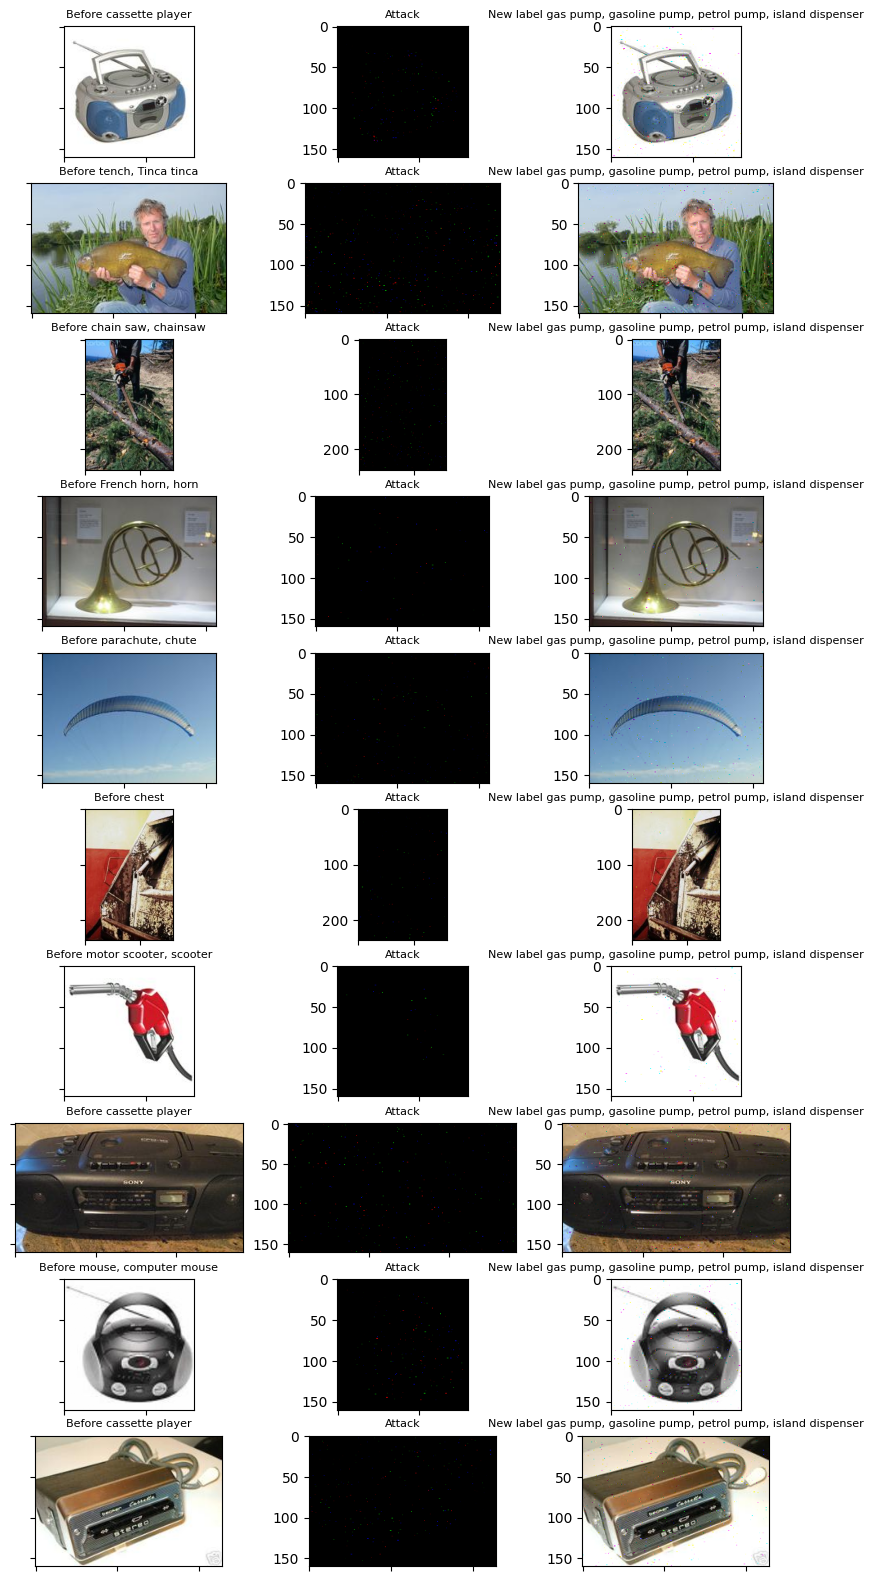

In [97]:
from matplotlib import pyplot as plt
import warnings
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 20), dpi=100)
warnings.filterwarnings("ignore", message=".*Clipping input data to the valid range for imshow with RGB data.*")
for i,ax in enumerate(axes):
    index = torch.randint(low=0, high=len(it), size=(1,)).item()
    # while new[index]["l"].item()!=571:
    #     index = torch.randint(low=0, high=len(it), size=(1,)).item()
    ax[0].imshow(np.transpose(init[index]["i"],(1,2,0))) 
    ax[0].set_title('Before '+labels[init[index]["l"].item()], fontsize=8)
    ax[0].set(xticklabels=[])
    ax[0].set(yticklabels=[])
    # ax[1].imshow(np.transpose(fakes[index]["i"],(1,2,0))) 
    # ax[1].set_title('Fake image index '+str(fakes[index]["l"]), fontsize=8)
    # ax[1].set(xticklabels=[])
    # ax[1].set_ylabel('')
    ax[2].imshow(np.transpose(new[index]["i"],(1,2,0)))
    ax[2].set_title('New label '+labels[new[index]["l"].item()], fontsize=8)
    ax[2].set(xticklabels=[])
    ax[2].set_ylabel('')
    # newimg = np.transpose(new[index]["i"], (1,2,0))
    # orimg = np.transpose(init[index]["i"], (1,2,0))
    # diff_mask = np.any(np.abs(newimg - orimg) > 0, axis=-1)  # create a binary mask for non-zero differences
    # diff_image = np.zeros_like(newimg)  # create an empty image for the output
    # diff_image[diff_mask] = [1, 1, 1]
    ax[1].imshow(np.transpose(new[index]["i"]-init[index]["i"], (1,2,0)))
    ax[1].set_title('Attack', fontsize=8)
    ax[1].set(xticklabels=[])
    ax[1].set_ylabel('')

plt.show()


VARIATIONS IN ORIGINAL DATASET DIMENSIONS


In [31]:
mxr,cr = 0,-1
mxc,ci = 0,-1
for i in range(len(it)):
    if mxr<new[i]["i"].size(1):
        mxr = new[i]["i"].size(1)
        ri = i
    if mxc<new[i]["i"].size(2):
        mxc = new[i]["i"].size(2)
        ci = i
# new[0]["i"].size(2), np.transpose(new[1]["i"], (1,2,0)).shape
mxr,mxc,ri,ci

(349, 612, 15, 49)

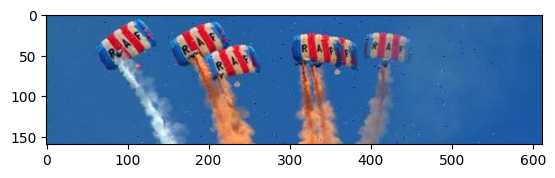

In [34]:
plt.imshow(np.transpose(new[49]["i"], (1,2,0)))  # WIDE IMAGE

NET ATTACK VISUALIZATION

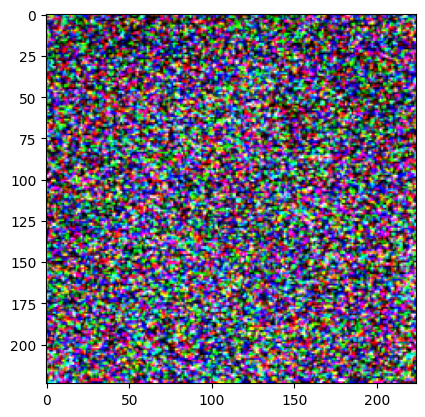

In [99]:
output_size = (224, 224)
transform = trans.Compose([
    trans.Resize(output_size),
    trans.CenterCrop(output_size)
])

# Load your tensor images and resize them

res = torch.zeros((3,224,224))
plt.imshow(np.transpose(res,(1,2,0)))
for i in range(len(it)):
    if new[i]["l"].item()!=571:
        continue
    tensor_image = new[i]["i"]-init[i]["i"]
    # Convert tensor_image from (3, row, col) to (row, col, 3) format
    # tensor_image = tensor_image.permute(1, 2, 0)

    # Convert tensor_image to a PIL image object
    pil_image = trans.ToPILImage()(tensor_image)
    
    # Apply the transformation to resize and crop/pad the image
    resized_image = transform(pil_image)

    
    # Convert the resized image back to a tensor and permute its dimensions to (3, 224, 224) format
    resized_tensor_image = trans.ToTensor()(resized_image) #.permute(1, 2, 0)
    
    # If the original image was smaller than the desired size, pad it with zeros
    if resized_tensor_image.shape != (3, 224, 224):
        padded_tensor_image = torch.zeros(3, 224, 224)
        padded_tensor_image[:, :resized_tensor_image.shape[1], :resized_tensor_image.shape[2]] = resized_tensor_image
        resized_tensor_image = padded_tensor_image
    
    # If the original image was larger than the desired size, crop it from the center
    if resized_tensor_image.shape != (3, 224, 224):
        crop_y = (resized_tensor_image.shape[1] - 224) // 2
        crop_x = (resized_tensor_image.shape[2] - 224) // 2
        resized_tensor_image = resized_tensor_image[:, crop_y:crop_y+224, crop_x:crop_x+224]
    
    res += resized_tensor_image
    # if i==10:
    # break
    
# plt.imshow(np.transpose(new[1]["i"]-init[1]["i"],(1,2,0)))
plt.imshow(np.transpose(res,(1,2,0)))
# plt.show()

In [100]:
labels[attacker.get_preds(res.unsqueeze(0)).item()]

'spotlight, spot'